https://www.sciencedirect.com/science/article/pii/003132039190081F
http://www.lps.usp.br/hae/apostila/convkeras-ead.pdf
http://yann.lecun.com/exdb/mnist/

https://www.kaggle.com/code/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc

http://ufldl.stanford.edu/housenumbers/

# **Importação de bibliotecas**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.io import loadmat

import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Importação e transformação dos dados**

In [4]:
!ls "/content/drive/My Drive/Teste_SVHN"

test_32x32.mat	train_32x32.mat


In [5]:
np.random.seed(100)

In [6]:
def carrega_dataset(caminho):
  # Carrega o dataset do drive
  banco = loadmat(caminho)

  imagens = np.array(banco['X'])
  imagens = np.moveaxis(imagens, -1, 0)

  # Carrega labels
  labels = banco['y']

  return imagens,labels

imagens_treino, labels_treino = carrega_dataset('/content/drive/My Drive/Teste_SVHN/train_32x32.mat')
imagens_teste, labels_teste = carrega_dataset('/content/drive/My Drive/Teste_SVHN/test_32x32.mat')


print(imagens_treino.shape)
print(imagens_teste.shape)
print(labels_treino.shape)
print(labels_teste.shape)


(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 1)
(26032, 1)


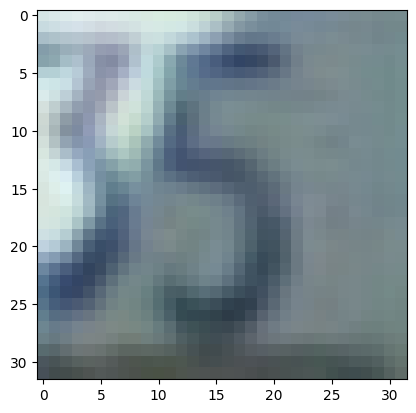

Label:  [5]


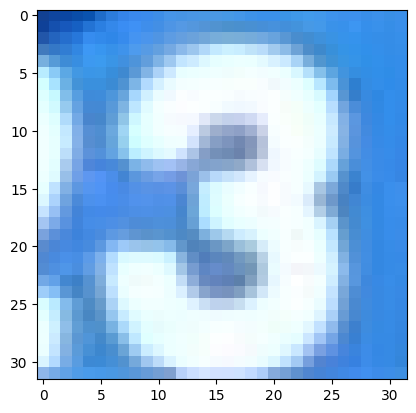

Label:  [3]


In [7]:
def exibe_imagem_label(imagens,labels,i):
  plt.imshow(imagens[i])
  plt.show()
  print('Label: ', labels[i])

exibe_imagem_label(imagens_treino,labels_treino,200)
exibe_imagem_label(imagens_treino,labels_treino,3)

In [8]:

def processa_imagens(imagens):
  imagens=imagens.astype('float64')
  imagens/=255.0 # Normalização das imagens
  return imagens

def processa_labels(labels):
  labels=labels.astype('int64')
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels) # Transforma labels em valor binário
  return labels

imagens_treino = processa_imagens(imagens_treino)
imagens_teste = processa_imagens(imagens_teste)
labels_treino = processa_labels(labels_treino)
labels_teste = processa_labels(labels_teste)

x_treino, x_teste, y_treino, y_teste = train_test_split(imagens_treino, labels_treino,
                                                  test_size=0.15, random_state=22)

x_treino = x_treino[:6000,:,:,:]
x_teste = x_teste[:1000,:,:,:]
y_treino = y_treino[:6000]
y_teste = y_teste[:1000]

In [9]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)


# Usando modelo novo para o SVHN


In [10]:
# Modelo para treino

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5',
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Treinamento

In [12]:

historico = model.fit_generator(datagen.flow(x_treino, y_treino, batch_size=128),
                              epochs=50, validation_data=(x_teste, y_teste),
                              callbacks=[early_stopping, model_checkpoint])


Epoch 1/50


<ipython-input-12-38b85772e77a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historico = model.fit_generator(datagen.flow(x_treino, y_treino, batch_size=128),


47/47 [==============================] - 60s 1s/step - loss: 1.9156 - accuracy: 0.2800 - val_loss: 1.7323 - val_accuracy: 0.3490
Epoch 2/50
47/47 [==============================] - 62s 1s/step - loss: 1.9221 - accuracy: 0.2755 - val_loss: 1.7591 - val_accuracy: 0.3830
Epoch 3/50
47/47 [==============================] - 62s 1s/step - loss: 1.9014 - accuracy: 0.2910 - val_loss: 1.6587 - val_accuracy: 0.3820
Epoch 4/50
47/47 [==============================] - 63s 1s/step - loss: 1.8765 - accuracy: 0.3007 - val_loss: 1.7594 - val_accuracy: 0.3560
Epoch 5/50
47/47 [==============================] - 60s 1s/step - loss: 1.8197 - accuracy: 0.3320 - val_loss: 1.6718 - val_accuracy: 0.3870
Epoch 6/50
47/47 [==============================] - 61s 1s/step - loss: 1.7587 - accuracy: 0.3698 - val_loss: 1.5043 - val_accuracy: 0.4870
Epoch 7/50
47/47 [==============================] - 60s 1s/step - loss: 1.7372 - accuracy: 0.3753 - val_loss: 1.3948 - val_accuracy: 0.5300
Epoch 8/50
47/47 [=============


## Resultados

In [13]:
# Evaluate train and validation accuracies and losses

treino_acuracia = historico.history['accuracy']
teste_acuracia = historico.history['val_accuracy']

treino_perda = historico.history['loss']
teste_perda = historico.history['val_loss']



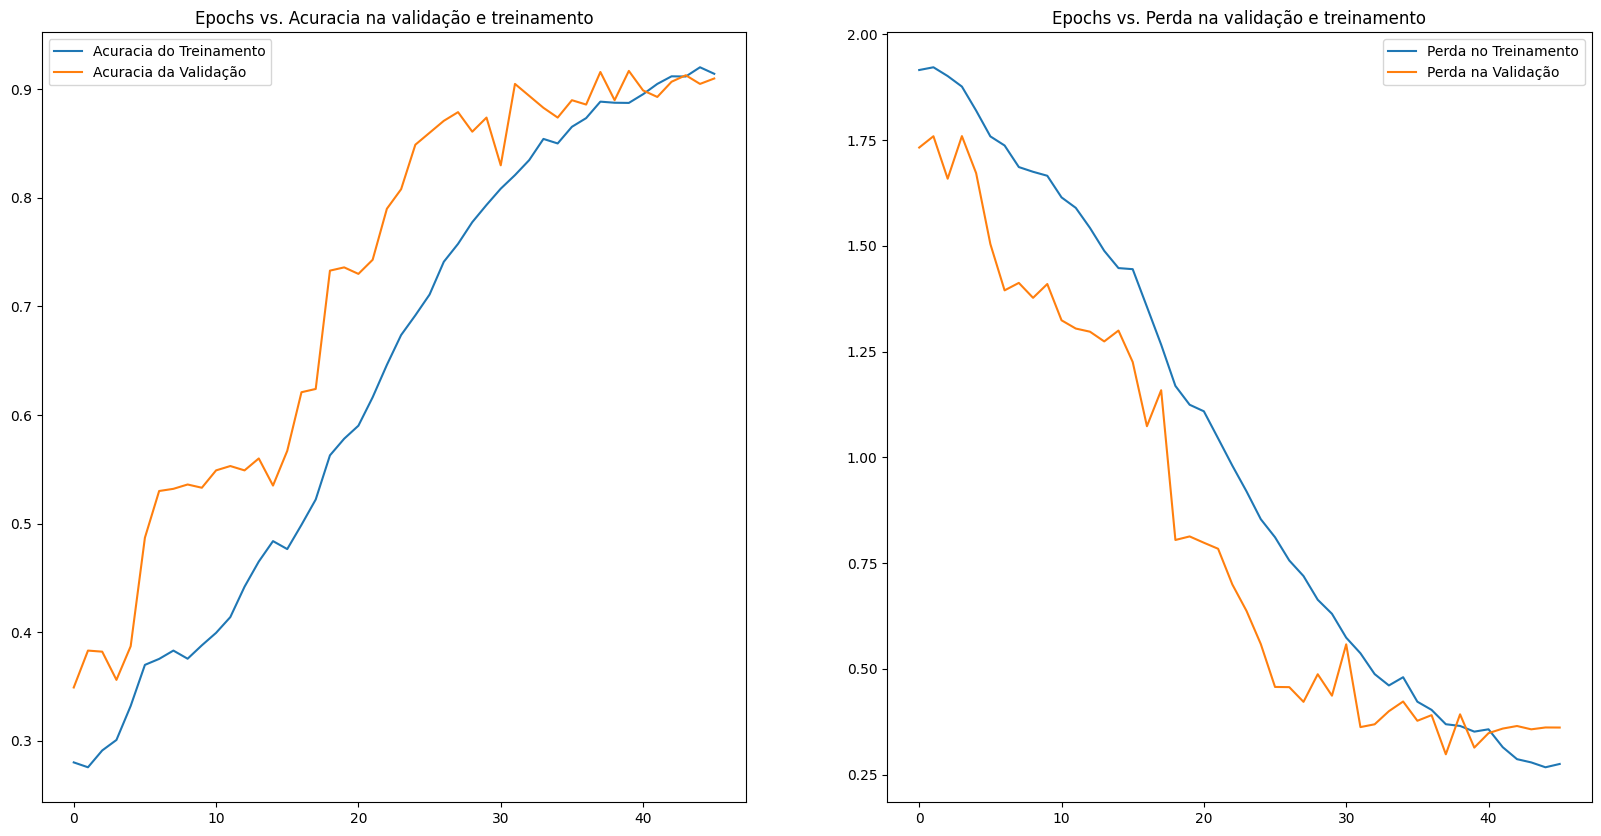

In [14]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(treino_acuracia, label='Acuracia do Treinamento')
plt.plot(teste_acuracia, label='Acuracia da Validação')
plt.legend()
plt.title('Epochs vs. Acuracia na validação e treinamento')

plt.subplot(1, 2, 2)
plt.plot(treino_perda, label='Perda no Treinamento')
plt.plot(teste_perda, label='Perda na Validação')
plt.legend()
plt.title('Epochs vs. Perda na validação e treinamento')

plt.show()

In [15]:
model.save('DigitsSVHN')